<a href="https://colab.research.google.com/github/OoJackoO/MMAI894_Deep-Learning-Course-Project/blob/dev/%5CIrfan%5CLoad_Tomato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 

Data Source: 

https://www.kaggle.com/datasets/cookiefinder/tomato-disease-multiple-sources  

Training set: train folder 

Validation and Test set: valid folder 

Reference: https://cs230.stanford.edu/blog/split/  

Random seed: 24 

In [1]:
# Import modules
# Add modules as needed
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from PIL import Image


from keras.utils import to_categorical
from keras import layers, regularizers
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, LayerNormalization, GlobalMaxPooling2D
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session


In [2]:
from google.colab import drive
drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/MMAI_894/Team_Assignment/'
#!kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources --path "/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# This function is just to get a list of dirs for the visualization and EDA functions
def define_paths(dir):
    filepaths = []
    labels = []
    #images = []
    folds = os.listdir(dir)
    print("The unique images labels are:", folds)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        print(foldpath)
        print(len(filelist),"files")
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    filepaths_array = np.array(filepaths)
    labels_array = np.array(labels)

    return filepaths_array, labels_array

#data_dir = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train')
data_dir = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/valid')
filepaths_array, labels_array = define_paths(data_dir)
print(filepaths_array.shape)
print(labels_array.shape)
print("Last loaded file", filepaths_array[-1])
print(labels_array[-1])


The unique images labels are: ['Early_blight', 'healthy', 'Leaf_Mold', 'powdery_mildew', 'Septoria_leaf_spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Late_blight', 'Bacterial_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_mosaic_virus']
/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/valid/Early_blight
643 files
/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/valid/healthy
801 files
/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/valid/Leaf_Mold
737 files
/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/valid/powdery_mildew
252 files
/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/valid/Septoria_leaf_spot
746 files
/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/valid/Tomato_Yellow_Leaf_Curl_Virus
498 fi

In [ ]:
# This function is used to check the images meet minimum size requirements for upscaling in preprocessing

from tqdm import tqdm
import cv2 as Cv2

def check_images(dir):
    filepaths = []
    labels = []
    images = []
    heights = []
    widths = []
    channels = []
    small_images =[]
    min_size = (112, 112)

    custom_format = "{l_bar}{bar}{r_bar} \U0001F34E"
    folds = os.listdir(dir)
    print("The unique images labels are:", folds,"\n\n")
    print(folds)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        print("Folder: ", foldpath)
        print(len(filelist),"files in folder")
        num_images_loaded = 0      
        for file in tqdm(filelist, colour='green', ascii=custom_format):
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    #img = Cv2.imread(fpath)
                    img = Cv2.imread(fpath, Cv2.IMREAD_UNCHANGED)
                    height,width,channels = img.shape

                    if img.shape[0] < min_size[0] or img.shape[1] < min_size[1]:
                      small_images.append(fpath) # save file path if too small
                    elif img.shape[0] > min_size[0] or img.shape[1] > min_size[1]:
                      heights.append(height)
                      widths.append(width)
                      #images.append(np.array(img))
                      num_images_loaded += 1
                      #img.close()
                      #img = mpimg.imread(fpath, file)
                      #images.append(img)
                    else:
                      pass
                 
                except Exception as e:
                    print(f"Error opening image: {e}")
            else:
                print(f"{file} is not a .jpg file")
        #num_images_loaded = len(images)
        print(num_images_loaded,"files loaded for a total of", len(images)," in memory")
        print(small_images)     

    filepaths_array = np.array(filepaths)
    labels_array = np.array(labels)
    images_array = images
    heights_array = np.array(heights)
    widths_array = np.array(widths)
    print("Maxheight:",heights_array.max())
    print("MaxWidth:",widths_array.max())
    print("Minheight:",heights_array.min())
    print("MinWidth:",widths_array.min())
    return filepaths_array, labels_array, images_array

data_dir = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train')
filepaths_array, labels_array, images_array = check_images(data_dir)

print("Total number of files paths loaded: ",filepaths_array.shape)
print("Total number of labels loaded: ",labels_array.shape)
print("Total number of images loaded: ",len(images_array))

   

The unique images labels are: ['Early_blight', 'Bacterial_spot', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew'] 


['Early_blight', 'Bacterial_spot', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
Folder:  /content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train/Early_blight
2448 files in folder


100%|🍎🍎🍎🍎🍎🍎🍎🍎🍎🍎| 2448/2448 [00:14<00:00, 171.76it/s]


2448 files loaded for a total of 0  in memory
[]
Folder:  /content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train/Bacterial_spot
2825 files in folder


100%|🍎🍎🍎🍎🍎🍎🍎🍎🍎🍎| 2825/2825 [00:16<00:00, 173.10it/s]


2825 files loaded for a total of 0  in memory
[]
Folder:  /content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train/Late_blight
3113 files in folder


100%|🍎🍎🍎🍎🍎🍎🍎🍎🍎🍎| 3113/3113 [00:23<00:00, 134.60it/s]


3113 files loaded for a total of 0  in memory
[]
Folder:  /content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train/Leaf_Mold
2737 files in folder


 99%|🍎🍎🍎🍎🍎🍎🍎🍎🍎r| 2706/2737 [00:14<00:00, 226.54it/s]

607-155-1.tosmall is not a .jpg file


100%|🍎🍎🍎🍎🍎🍎🍎🍎🍎🍎| 2737/2737 [00:15<00:00, 181.21it/s]


2736 files loaded for a total of 0  in memory
[]
Folder:  /content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train/Septoria_leaf_spot
2881 files in folder


100%|🍎🍎🍎🍎🍎🍎🍎🍎🍎🍎| 2881/2881 [00:21<00:00, 134.55it/s]


2881 files loaded for a total of 0  in memory
[]
Folder:  /content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train/Spider_mites Two-spotted_spider_mite
1747 files in folder


100%|🍎🍎🍎🍎🍎🍎🍎🍎🍎🍎| 1747/1747 [00:08<00:00, 204.97it/s]


1747 files loaded for a total of 0  in memory
[]
Folder:  /content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train/Target_Spot
1827 files in folder


100%|🍎🍎🍎🍎🍎🍎🍎🍎🍎🍎| 1827/1827 [00:09<00:00, 191.92it/s]


1827 files loaded for a total of 0  in memory
[]
Folder:  /content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train/Tomato_Yellow_Leaf_Curl_Virus
2034 files in folder


100%|🍎🍎🍎🍎🍎🍎🍎🍎🍎🍎| 2034/2034 [00:10<00:00, 194.12it/s]


2034 files loaded for a total of 0  in memory
[]
Folder:  /content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train/Tomato_mosaic_virus
1744 files in folder


100%|🍎🍎🍎🍎🍎🍎🍎🍎🍎🍎| 1744/1744 [00:12<00:00, 134.51it/s]


1744 files loaded for a total of 0  in memory
[]
Folder:  /content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train/healthy
3047 files in folder


100%|🍎🍎🍎🍎🍎🍎🍎🍎🍎🍎| 3047/3047 [00:22<00:00, 138.48it/s]


3047 files loaded for a total of 0  in memory
[]
Folder:  /content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train/powdery_mildew
1004 files in folder


100%|🍎🍎🍎🍎🍎🍎🍎🍎🍎🍎| 1004/1004 [00:04<00:00, 228.78it/s]


1004 files loaded for a total of 0  in memory
[]
Maxheight: 3370
MaxWidth: 4416
Minheight: 137
MinWidth: 142
Total number of files paths loaded:  (25407,)
Total number of labels loaded:  (25407,)
Total number of images loaded:  0


6
227 227 3
227 227 3
227 227 3
227 227 3
227 227 3
227 227 3


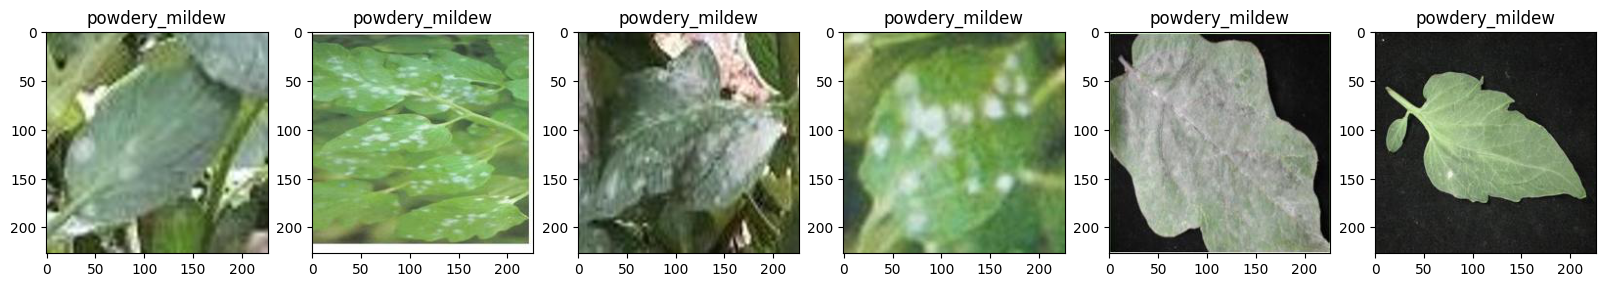

In [ ]:
def visualize(filepaths_array,labels_array):
  num_images = len(filepaths_array)
  fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(20,20))
  print(num_images)
# Display each image on a separate axis
  for i, images_array in enumerate(filepaths_array):
      #print(filepaths_array[i])
      image = mpimg.imread(filepaths_array[i])
      height, width, channels = image.shape
      ax[i].imshow(image)
      print(height, width, channels)
      #ax[i].set_xticks([])
      #ax[i].set_yticks([])
      ax[i].set_title(labels_array[i])

stop = len(filepaths_array)
start = stop-6

visualize(filepaths_array[start:stop], labels_array[start:stop])


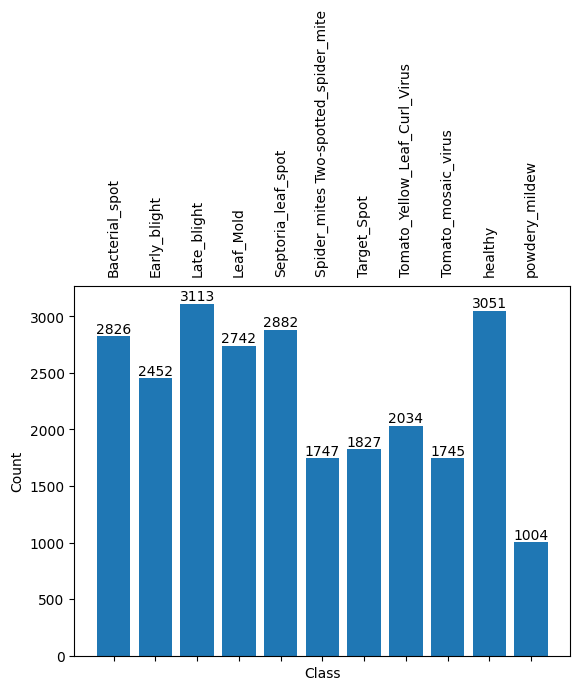

In [ ]:
def data_distribution(labels_array):
  # Get the count of each label
  unique_labels, counts = np.unique(labels_array, return_counts=True)

# Use a bar chart to show the distribution of labels
  bars = plt.bar(np.arange(len(counts)), counts)
  plt.xticks(np.arange(len(counts)), unique_labels, rotation=90)
  plt.tick_params(labeltop=True, labelbottom=False)
  plt.xlabel('Class')
  plt.ylabel('Count')
  plt.bar_label(bars, labels=counts, label_type='edge', fontsize=10)
  plt.show()

data_distribution(labels_array)


In [4]:
from tqdm import tqdm
from keras.applications.mobilenet_v2 import preprocess_input

# This functions builds a generator (allows for batch loading of the images to save on memory !this was the problem I initially had!)
#-> splits images into batches,
# Preprocess each image to be normalized to the mean and stddev of MobilenetV2 and scaled betwee [-1,1] as required by MobilenetV2,
# Reshapes each image to the specified pixel height and width,
# Extracts the category classes, 
# One hot encoded the catergories

def loadtrain_images(dir, params={}):

  data_dir = dir
  height=params['IMG_HEIGHT'] 
  width=params['IMG_WIDTH'] 
  random_seed = params['random_seed']
  batch_size = params['batch_size']

  data_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  
  train_generator = data_datagen.flow_from_directory(
      data_dir,
      target_size = (height,width),
      color_mode='rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      subset='training',
      shuffle=True,
      seed=random_seed
  )
  return train_generator

def loadsplit_val_images(dir, params={}):

  data_dir = dir
  height=params['IMG_HEIGHT'] 
  width=params['IMG_WIDTH'] 
  data_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.5)
  
  random_seed = params['random_seed']
  batch_size = params['batch_size']

  val_generator = data_datagen.flow_from_directory(
      data_dir,
      target_size = (height,width),
      color_mode='rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      subset='training',
      shuffle=True,
      seed=random_seed
  )
  
  test_generator = data_datagen.flow_from_directory(
      data_dir,
      target_size = (height,width),
      color_mode='rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      subset='validation',
      shuffle=True,
      seed=random_seed
  )
  return val_generator, test_generator


params= {'IMG_HEIGHT': 224, 'IMG_WIDTH': 224, 'batch_size':128, 'random_seed':24}

data_dir = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train')
train_gen = loadtrain_images(data_dir, params=params) 

data_dir = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/valid')
val_gen, test_gen = loadsplit_val_images(data_dir, params=params) 



total_samples = train_gen.samples + val_gen.samples + test_gen.samples
print("\nTotal number of samples:", total_samples)
print("Number of training image samples:", train_gen.samples)
print("Number of validation image samples:", val_gen.samples)
print("Number of test image samples:", test_gen.samples)
print("\nX_train % split:", train_gen.samples / total_samples*100,"%")
print("X_val % split:", val_gen.samples / total_samples*100,"%")
print("X_test % split:", test_gen.samples / total_samples*100,"%")
print("Batch size:", params['batch_size'])


Found 25406 images belonging to 11 classes.
Found 3569 images belonging to 11 classes.
Found 3565 images belonging to 11 classes.

Total number of samples: 32540
Number of training image samples: 25406
Number of validation image samples: 3569
Number of test image samples: 3565

X_train % split: 78.0762138905962 %
X_val % split: 10.968039336201597 %
X_test % split: 10.955746773202213 %
Batch size: 128


In [5]:
clear_session()

def build_model_CNN():
  
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size = (4, 4), activation = 'relu', input_shape=(224, 224, 3),strides = (1,1), padding = "same", name="Convolution_Layer1"))
    model.add(layers.MaxPool2D(2,2))
    model.add(Conv2D(filters=64, kernel_size=(4, 4), activation = 'relu', strides=(1,1), padding="same", name="Convolution_Layer2"))
    model.add(layers.MaxPool2D(2,2))
    model.add(Conv2D(64, (4, 4), activation = 'relu', strides=(1,1), padding="same",name="Convolution_Layer3"))
    model.add(layers.Flatten(name="Flatten_layer"))

    
    #Layer 1 with 64 nodes and relu activation. Input will get calcualted by Keras
    # A single Dense layer looked to give suffecient performance as compared to adding two layers i.e. not too much benefit was observed in this case by having two dense layers
    #model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001), name="Layer_1"))
    #Add dropout of 0.30 (this number was arrived upon via hyperparameter tuning)
    model.add(Dropout(0.30))
    #Added an Batch normalization layer to help improve performance - this didn't help
    #model.add(BatchNormalization())
    #Output with softmax activation and 11 out out layers corresponding to the output classes
    model.add(Dense(11, activation='softmax',  name="Output"))
    #Lets see how the model looks
    model.summary()   
    #print(model.get_layer("Flatten_layer").output_shape)

    return model

model_CNN = build_model_CNN()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Convolution_Layer1 (Conv2D)  (None, 224, 224, 32)     1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 Convolution_Layer2 (Conv2D)  (None, 112, 112, 64)     32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 Convolution_Layer3 (Conv2D)  (None, 56, 56, 64)       65600     
                                                                 
 Flatten_layer (Flatten)     (None, 200704)            0

In [6]:
#Lets do transfer learning using a baseline model of MobilenetV2
from tensorflow.keras.applications import MobileNetV2

clear_session()
def build_model_MobileNetV2():
    
    #Pre-Trained transfer learning network or the base model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    #Classification head
    model = Sequential()
    model.add(base_model)
    model.add(GlobalMaxPooling2D())
    # Layer 1 with 64 nodes and relu activation. Input will get calcualted by Keras
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001), name="Class_Layer_1"))
    # Add dropout of 0.30 (this number was arrived upon via hyperparameter tuning)
    model.add(Dropout(0.30))
    # Added an Batch normalization layer to help improve performance
    model.add(BatchNormalization())
    model.add(Dense(11, activation='softmax', name='Output_Layer'))

    model.summary()
    return model

model_MobileNetV2 = build_model_MobileNetV2()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 Class_Layer_1 (Dense)       (None, 64)                81984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                             

In [7]:
def compile_model(model):
  
    #Lets try different optimizers as well as learning rates to see if it helps
    optimizer = Adam()
    #optimizer = Adam(learning_rate=0.001)
    #optimizer = RMSprop()
    loss = CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

model_CNN = compile_model(model_CNN)
#model_MobileNetV2 = compile_model(model_MobileNetV2)

In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Mar 30 14:19:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    51W / 400W |    725MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
def train_model(model, XY_train, XY_val, batch_size, epochs):
  
    # Lets add early stopping if the val loss doesn't improve after 3 epochs
    best_weights_file = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/best_weights.h5')
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
    checkpoint = ModelCheckpoint(filepath = best_weights_file, monitor='val_loss', save_best_only=True, mode='min')

    # Using 12-20 epochs and including validation data. Also added verbose to monitor output with early stopping. 
    # Can use early stopping as well buthave it commented out for this instance
    # history = model.fit(X_train, Y_train, epochs=20, batch_size=64,verbose=1, validation_data=(X_val, Y_val), callbacks=[early_stopping, checkpoint])
    history = model.fit(XY_train, steps_per_epoch=XY_train.samples // batch_size,
                        epochs=epochs, batch_size=batch_size, verbose=1, 
                        validation_data=(XY_val), validation_steps=XY_val.samples // batch_size,
                        callbacks=[early_stopping, checkpoint])

    return model, history

clear_session()
#Comment and uncomment the model you want to run i.e. CNN or Transferlearning from MobilenetV2

model = model_CNN
#model = model_MobileNetV2
model, history = train_model(model, train_gen, val_gen, batch_size=128, epochs=12)

Epoch 1/12
198/198 [==============================] - 9633s 48s/step - loss: 1.5114 - accuracy: 0.5951 - val_loss: 1.5996 - val_accuracy: 0.5938
Epoch 2/12
198/198 [==============================] - 140s 709ms/step - loss: 1.1559 - accuracy: 0.7493 - val_loss: 1.5568 - val_accuracy: 0.6441
Epoch 3/12
198/198 [==============================] - 139s 702ms/step - loss: 1.0428 - accuracy: 0.8012 - val_loss: 1.4823 - val_accuracy: 0.6690
Epoch 4/12
198/198 [==============================] - 139s 702ms/step - loss: 0.9389 - accuracy: 0.8530 - val_loss: 1.3553 - val_accuracy: 0.6979
Epoch 5/12
198/198 [==============================] - 138s 697ms/step - loss: 0.8497 - accuracy: 0.8975 - val_loss: 1.4855 - val_accuracy: 0.6826
Epoch 6/12
198/198 [==============================] - 138s 699ms/step - loss: 0.7629 - accuracy: 0.9415 - val_loss: 1.4539 - val_accuracy: 0.7156
Epoch 7/12
198/198 [==============================] - 139s 701ms/step - loss: 0.6857 - accuracy: 0.9759 - val_loss: 1.3997 - 

In [16]:
model.save('/content/drive/MyDrive/MMAI_894/Team_Assignment/CNN_model.h5')
#model.save('/content/drive/MyDrive/MMAI_894/Team_Assignment/MobilenetV2_with_simple_classificationhead.h5')


In [ ]:
model = load_model('/content/drive/MyDrive/MMAI_894/Team_Assignment/MobilenetV2_with_simple_classificationhead.h5')
history = model.history

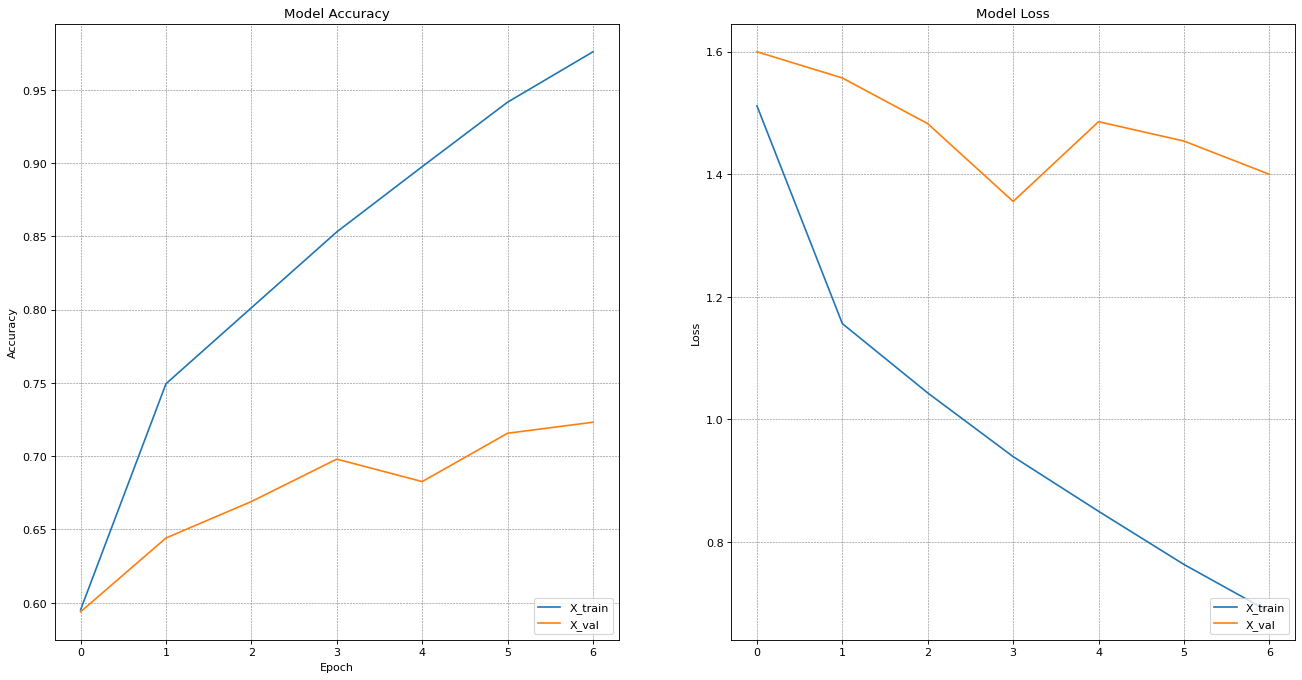

In [11]:
def plot_overfitting(model, history):
    fig = plt.figure(figsize=(20, 10), dpi=80)
    ax1 = fig.add_subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['X_train', 'X_val'], loc='lower right')
    ax1.grid(axis='both', color='gray', linestyle='--', linewidth=0.5)

    # Lets plot the loss of training and validation data to ensure we are not overfitting
    ax1 = fig.add_subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.legend(['X_train', 'X_val'], loc='lower right')
    ax1.grid(axis='both', color='gray', linestyle='--', linewidth=0.5)
    plt.show()
    # plt.gca().set_ylim(0,1)

plot_overfitting(model, history)

In [14]:
def eval_model(model, test_generator):
    
    best_weights_file = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/best_weights.h5')
    model.load_weights(best_weights_file)
    #custom_format = "{l_bar}{bar}{r_bar} \U0001F34E"
    #tqdm_callback = tqdm(colour='green', ascii=custom_format)
    #tqdm_callback = tfa.callbacks.TQDMProgressBar(colour='green', ascii=custom_format)
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

    return test_loss, test_accuracy


test_loss, test_accuracy = eval_model(model, test_gen)
# added this line as want to see what the predicted classification for an input of X_test is
#output = model.predict(X_test)

print("\nTest data set Accuracy = ", test_accuracy*100,"%")
print("Test data set Loss = ", test_loss*100,"%")

28/28 [==============================] - 1141s 42s/step - loss: 0.9118 - accuracy: 0.8642

Test data set Accuracy =  86.42356395721436 %
Test data set Loss =  91.18205308914185 %


In [15]:
output = model.predict(test_gen)

28/28 [==============================] - 16s 553ms/step


In [ ]:
y_true = np.array([])
for x, y in test_gen:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
(3565,)


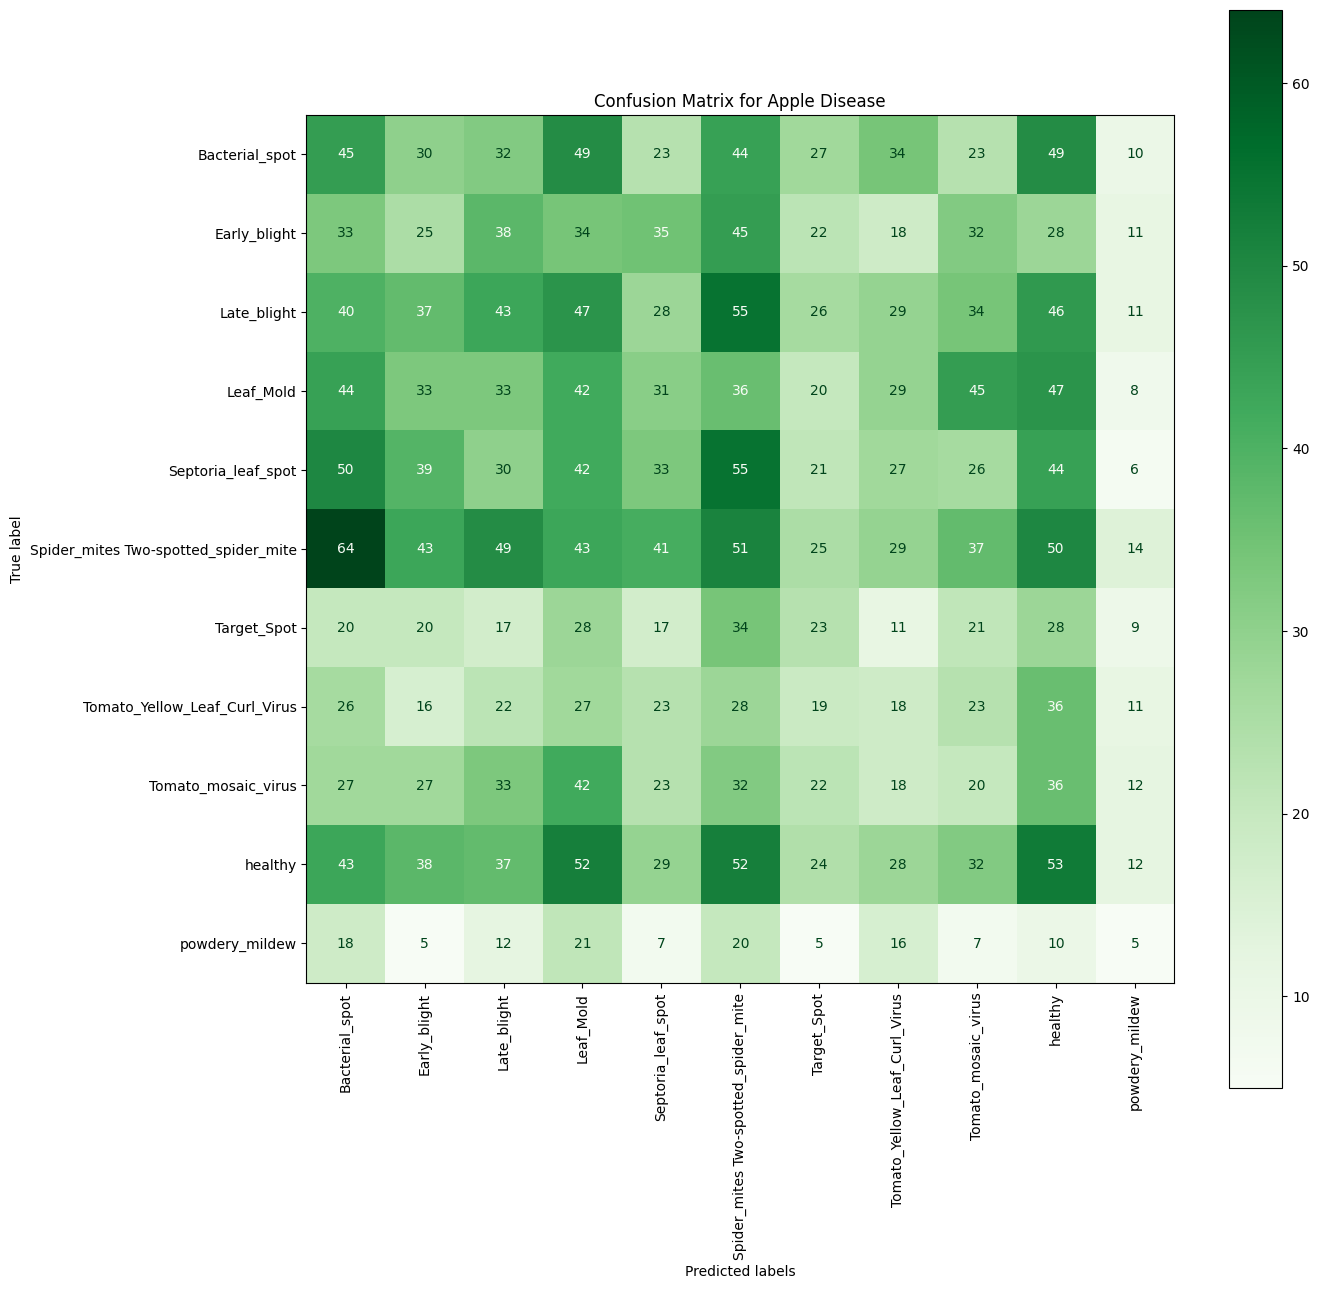

In [17]:
def plt_confusion_mtrx(output, Y_true, class_labels):
      Y_predicted = np.argmax(output, axis=1)
      #print(Y_predicted[0:300],Y_true[0:300])
      #class_to_str = np.vectorize(lambda x:class_labels[x])
      #Y_true_str = class_to_str(Y_true)
      #print(Y_true_str[1900:1984])

      conf_mtx = confusion_matrix(Y_true, Y_predicted)
      disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtx, display_labels=class_labels)
      # Plot confusion matrix
      fig, ax = plt.subplots(figsize=(14,14))
      disp.plot(cmap='Greens',ax=ax)
      ax.set_title ('Confusion Matrix for Apple Disease')
      ax.set_xlabel('Predicted labels')
      ax.set_ylabel('True label')
      ax.set_xticklabels(class_labels, rotation=90)
      # Show plot
      plt.show()

Y_true = test_gen.classes
class_labels = list(train_gen.class_indices)
print(class_labels)
print(Y_true.shape)
plt_confusion_mtrx(output, Y_true, class_labels)

#Everything after this is either depracated or experimaental

In [ ]:
from tqdm import tqdm
from keras.applications.mobilenet_v2 import preprocess_input

# This functions builds a generator -> splits images into batches, normalizes each image, reshapes each image to the specified size, extracts the category classes, one hot encoded the catergories
def loadandsplit_images(dir, train_or_val, params={}):

  data_dir = dir
  height=params['IMG_HEIGHT'] 
  width=params['IMG_WIDTH'] 
  random_seed = params['random_seed']
  batch_size = params['batch_size']

  if train_or_val == 'val':
    data_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.5)
    val_iterator = data_datagen.flow_from_directory(
                   data_dir,
                   target_size = (height,width),
                   color_mode='rgb',
                   batch_size = batch_size,
                   class_mode = 'categorical',
                   subset='training',
                   shuffle=True,
                   seed=random_seed
                  )
    print("\nTotal number of Validation samples:", val_iterator.samples)
    test_iterator = data_datagen.flow_from_directory(
                   data_dir,
                   target_size = (height,width),
                   color_mode='rgb',
                   batch_size = batch_size,
                   class_mode = 'categorical',
                   subset='validation',
                   shuffle=True,
                   seed=random_seed
                  )
    print("\nTotal number of pseudo_Test samples:", test_iterator.samples)
    return val_iterator, test_iterator
  elif train_or_val == 'train':
    data_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_iterator = data_datagen.flow_from_directory(
                    data_dir,
                    target_size = (height,width),
                    color_mode='rgb',
                    batch_size = batch_size,
                    class_mode = 'categorical',
                    subset='training',
                    shuffle=True,
                    seed=random_seed
                    )
    print("\nTotal number of Training samples:", train_iterator.samples)
    return train_iterator
    
  else:
    return
    

params= {'IMG_HEIGHT': 224, 'IMG_WIDTH': 224, 'batch_size':128, 'random_seed':24}

#train_dir = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train')
#train_gen = loadandsplit_images(train_dir, train_or_val='train', params=params) 

val_dir = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train')
val_gen, test_gen = loadandsplit_images(val_dir, train_or_val='val', params=params)